## <center><strong>Notebook describtion & Our <span style= 'color: #51fcc6'>Questions</span>

In this notebook we are going to create the charts that we are going to use in the final pdf report and the tools we are going<br>
to use are matplotlib and seaborn.

#### **Questions we are going to awnser:**
1. How many jobs are available per country and per profession on Likedin.

2. What's the ratio between people who earned money on UpWork Vs Guru.

3. Average salary per profession and per country on LinkedIn.

4. What's Top 5 people in earnings amount most frequent words in thier describtions.<sub> *(In upwork</sub>

5. What's Worst 5 people in earnings amount most frequent words in thier describtions.<sub> *(In upwork)</sub>


6. What are the most appending skills in the job titels per profession.<sub> *(In upwork & LinkedIn)</sub>

7. What are the Top 10 skills in earnings. <sub> *(In upwork & LinkedIn)</sub>

8. Correlation between Earnings amount, Years of Exp, Hour rate & Feedback in Upwork.

9. Does the Consultations offers affect the Earnings amount strongly.

10. Top 3 countries in total freelancers earnings Vs Top 3 countries in freelancers count <sub> *(In upwork & guru)</sub>

11. Jobs count per Jobs location per profession.

12. Where are the most job loactions in general per profession.

13. What's the average salary per proffision & per country.

14. What's the most common Employment type per data jobs in general.

15. Jobs count vs listing dates per proffision to see thier growth trends.

16. most common Earning abount, hour rate, exp years per proffision in Upwork.

#### **Important note:**
I am going to use  **`pandasql`** to read the data from the dfs so I can create plots more easly using SQL<br>
queries inside python.

## <center><strong>Importing the <span style= 'color: #48e0dc'>Packeges 

In [17]:
import os
import warnings
import matplotlib
import pandasql           as ps
import pandas             as pd
import numpy              as np
import seaborn            as sns
import matplotlib.pyplot  as plt

from google.cloud         import bigquery
from wordcloud            import WordCloud
from collections          import Counter

In [18]:
%matplotlib inline
plt.rcParams['font.family'] = 'Candara'

warnings.filterwarnings('ignore')

credentials_path :str = '../credentials.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credentials_path

FONT             :int  = 20
COLORS           :list = ['#51fcc6', '#48e0dc', '#5cd3f7', '#4895e0', '#517afc']
NUMERICS         :list = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64',
                          'uint16', 'uint32', 'uint64']

## <center><strong>Loading the data & basic data <span style= 'color: #5cd3f7'>Cleaning

In [19]:
project_id :str = 'data-jobs-analysis-db'
dataset_id :str = 'data_jobs_analysis_db'

query_pandas  = lambda q: ps.sqldf(q, globals())
client        = bigquery.Client(project= project_id)

linkedin_jobs    = client.query(f'SELECT * FROM {dataset_id}.linkedin_jobs_new;').to_dataframe()
upwork_profiles  = client.query(f'SELECT * FROM {dataset_id}.upwork_profiles_new;').to_dataframe()
guru_profiles    = client.query(f'SELECT * FROM {dataset_id}.guru_profiles_new;').to_dataframe()

In [4]:
cm = sns.light_palette(COLORS[0], as_cmap=True)

linkedin_jobs.drop(['describtion', 'jobs_links', 'jobs_titles', 'skills']
                   , axis= 1).sample(5).style.background_gradient(cmap= cm)

In [5]:
cm = sns.light_palette(COLORS[2], as_cmap=True)

upwork_profiles.drop(['describtion', 'skills']
                   , axis= 1).sample(5).style.background_gradient(cmap= cm)

In [6]:
cm = sns.light_palette(COLORS[4], as_cmap=True)

guru_profiles.drop(['describtion', 'skills']
                   , axis= 1).sample(5).style.background_gradient(cmap= cm)

#### **Basic cleaning:**

In [7]:
def tucky_method(array: np.array, indecies= True) -> np.array:
    """
    This function works with any list-like numerical object
    (don't work with pandas series's) and returns the indexes
    of the found outliers in the array.
    
    :Params: Takes only the series.
    :Returns: S list of the outliers indexes.
    """
    
    Q3 = np.quantile(array, 0.75)
    Q1 = np.quantile(array, 0.25)
    IQR = Q3 - Q1
    
    upper_range = Q3 + (IQR * 1.5)
    lower_range = Q1 - (IQR * 1.5)
    
    outliers = [x for x in array if ((x < lower_range) | (x > upper_range))]
    print(f"Found {len(outliers)} outliers from {len(array)} length series!")
    
    return outliers

In [8]:
upwork_profiles.drop(['Unnamed__0', 'new_columns'], axis= 1, inplace= True)
guru_profiles.drop(['Unnamed__0', 'new_columns'], axis= 1, inplace= True)

linkedin_jobs.drop(['jobs_links'], axis= 1, inplace= True)

linkedin_jobs['salary'] = linkedin_jobs['salary'].where((linkedin_jobs.salary < 70) |
                                                        (linkedin_jobs.salary > 10_000) &
                                                        (linkedin_jobs.salary > 5))

per_hour_or_year_map = lambda salary: 'per year' if salary > 10_000 else 'per hour' if salary < 100 else np.nan
linkedin_jobs['per_hour_or_year'] = linkedin_jobs['salary'].apply(per_hour_or_year_map)

In [9]:
outliers = tucky_method(linkedin_jobs[linkedin_jobs['per_hour_or_year'] == 'per year']['salary'].to_numpy())
outliers_indexes = np.array(*np.where(np.isin(linkedin_jobs['salary'], outliers)))
linkedin_jobs = linkedin_jobs.drop(outliers_indexes)

# outliers = z_score(linkedin_jobs['salary'].to_numpy())
# outliers_indexes = np.array(*np.where(np.isin(base_videos['viewCount'], outliers)))
# temp_base_videos = base_videos.drop(outliers_indexes)


Found 77 outliers from 964 length series!


## <center><strong><span style= 'color: #5cd3f7'>Visualizing</span> the data (part 1)

In [10]:
def add_bar_labels(x,y, ax, scaler= 0):
    for i in range(len(x)):
        ax.text(i, y[i] + scaler , '{:,}'.format(y[i]), ha = 'center')

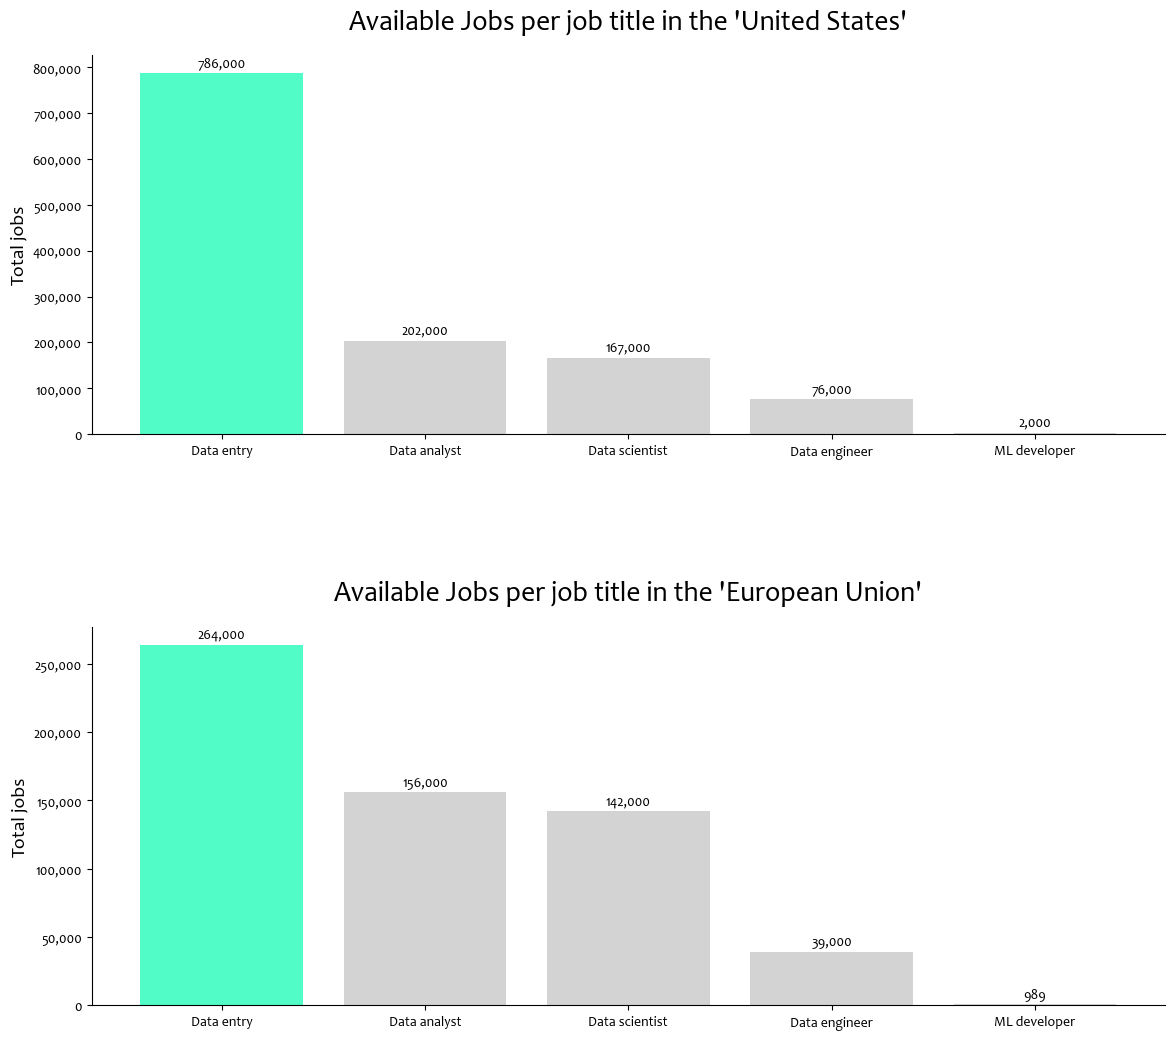

In [11]:
fig, (ax1, ax2) = plt.subplots(nrows= 2)

countries = ['\'United States\'', '\'European Union\'']

colors_temp = [COLORS[0]] * 1
colors_temp += ['lightgrey'] * 5

for ax, country in zip([ax1, ax2], countries):
    
    data = query_pandas(f'''SELECT total_jobs,
                                 job_title,
                                 country
                           FROM linkedin_jobs
                           WHERE country = {country}
                           GROUP BY job_title
                           ORDER BY total_jobs DESC;''')
    
    ax.bar(x=      data['job_title'],
           height= data['total_jobs'],
           color=  colors_temp)
    
    ax.spines[['right', 'top']].set_visible(False)

    ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    ax.set_title(f'Available Jobs per job title in the {country}', fontsize= FONT, pad= 19)
    ax.set_ylabel('Total jobs', fontsize= FONT * 3.5/5)
    
    if ax is ax1:
        add_bar_labels(data['job_title'], data['total_jobs'], ax, scaler= 15000)
        
    if ax is ax2:
        add_bar_labels(data['job_title'], data['total_jobs'], ax, scaler= 5000)

        
fig.tight_layout(h_pad=0.5, w_pad=5)
fig.set_size_inches(13, 12)
plt.show()

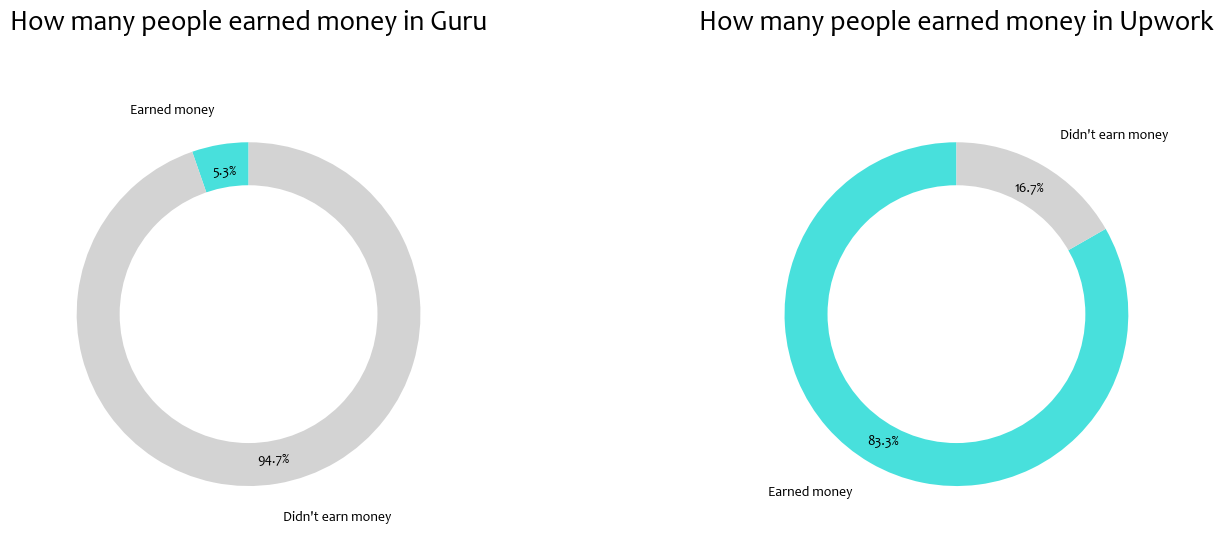

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

platforms   : list = ['guru', 'upwork']
labels      : list = ['Earned money', 'Didn\'t earn money']
colors_temp : list = [COLORS[1], 'lightgrey']
explode     : list = [0.2, 0.2]

for ax, platform in zip([ax1, ax2], platforms):
    # The first row in the queried table below contains the people who have earned money count
    data = query_pandas(f'''SELECT COUNT(*) AS total_profiles
                           FROM {platform}_profiles
                           WHERE earnings_amount_new > 0
                           
                           UNION ALL
                           
                           SELECT COUNT(*) AS total_profiles
                           FROM {platform}_profiles
                           WHERE earnings_amount_new IS NULL OR 
                                 earnings_amount_new = 0;''')


    # Plot the pie chart on the current axis
    # ax.pie(counts, labels=labels, autopct='%2.1f%%', pctdistance=0.85, labeldistance=1.2, colors= colors_temp)
    
    ax.pie(data['total_profiles'], labels=labels, autopct='%2.1f%%',
           pctdistance=0.85, labeldistance=1.2, colors=colors_temp,
           startangle=90)
    
    ax.set_title(f'How many people earned money in {platform.title()}', fontsize= FONT, pad= 50)
                 
    centre_circle = plt.Circle((0, 0), 0.75, fc='white')
    ax.add_artist(centre_circle)

fig.tight_layout(w_pad=7)
fig.set_size_inches(13, 10)
plt.show()

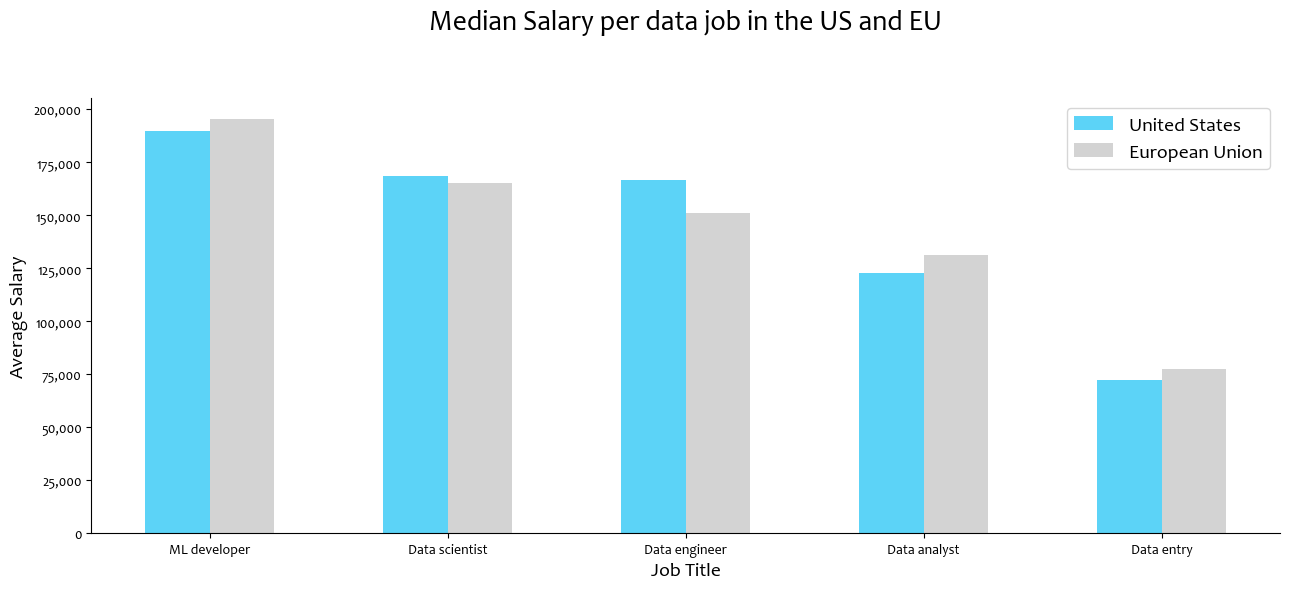

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)

width = 0.27

data = query_pandas(f'''SELECT AVG(salary) AS avg_salary,
                               country,
                               job_title

                        FROM linkedin_jobs
                        WHERE salary > 100 
                        GROUP BY country, job_title
                        ORDER BY avg_salary DESC;''')

us_data = data[data['country'] == 'United States']
eu_data = data[data['country'] == 'European Union']

positions_us = range(len(us_data))
positions_eu = [pos + width for pos in positions_us]


ax.bar(positions_us, us_data['avg_salary'], width,
       align='center', label='United States',
       color= COLORS[2])

ax.bar(positions_eu, eu_data['avg_salary'], width,
       align='center', label='European Union',
       color= 'lightgrey')


ax.spines[['right', 'top']].set_visible(False)
ax.set_xticks([pos + width/2 for pos in positions_us])
ax.set_xticklabels(us_data['job_title'], ha='center')

ax.set_title(f'Median Salary per data job in the US and EU', fontsize= FONT, pad= 50)
ax.set_xlabel('Job Title',      fontsize= FONT * 3.5/5)
ax.set_ylabel('Average Salary', fontsize= FONT * 3.5/5)


ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.legend(fontsize="14")
fig.set_size_inches(13, 6)
fig.tight_layout()
plt.show()

In [15]:
linkedin_jobs.sample(30)

jobs_locations listing_dates  \
1374      Palo Alto, CA    2023-06-23   
2778     Menlo Park, CA    2023-03-21   
133   San Francisco, CA    2022-03-02   
2595  San Francisco, CA    2023-06-10   
737   San Francisco, CA    2023-05-23   
309        San Jose, CA    2023-05-23   
335      Menlo Park, CA    2023-06-02   
1822        Hayward, CA    2023-05-25   
1883     Menlo Park, CA    2023-07-18   
3287  San Francisco, CA    2023-07-18   
16          Concord, CA    2023-07-20   
419      San Rafael, CA    2023-06-27   
2388      Palo Alto, CA    2023-03-28   
2756       Saratoga, CA    2023-03-21   
1153  San Francisco, CA    2023-07-06   
2366  San Francisco, CA    2023-03-28   
2666       San Jose, CA    2023-05-11   
698   San Francisco, CA    2023-07-04   
2951       Saratoga, CA    2022-12-06   
3280     Santa Rosa, CA    2023-07-17   
3016        Concord, CA    2023-07-06   
396      Santa Rosa, CA    2023-06-29   
2609     Pleasanton, CA    2023-06-26   
521        San Jose, CA    2023-07-09   
1591       San Jose, CA    2023-05-11   
1430         Newark, CA    2023-06-28   
2105  Mountain View, CA    2023-07-19   
3376       Stanford, CA    2023-06-30   
2181        Fremont, CA    2023-06-29   
540        San Jose, CA    2023-07-09   

                                            jobs_titles  \
1374                                  Research Engineer   
2778                   Senior Systems Software Engineer   
133                        Data Infrastructure Engineer   
2595                                     Data Scientist   
737                        Data Scientist (Experienced)   
309                                             Cashier   
335                       Metaverse QoE System Engineer   
1822                                    System Engineer   
1883                       Administrative/HR Specialist   
3287  Transportation Program Specialist / Transporta...   
16                      Back End Scheduling Coordinator   
419                                Senior Data Engineer   
2388                                 Sr. Data Scientist   
2756                   Senior Systems Software Engineer   
1153  Senior Software Engineer - Database Engine Int...   
2366                                     Data Scientist   
2666                                    BI Data analyst   
698                                    Python Developer   
2951  High Performance Computer Software Engineer (H...   
3280                         Administrative Coordinator   
3016                               Sr Database Engineer   
396                                     System Engineer   
2609   Web Analytics Engineer/Adobe Analytics Engineer.   
521                     Data Defense Operations Analyst   
1591                                     Data Scientist   
1430  Perception - Deep Learning Algorithm Engineer,...   
2105                           Senior GCP Data Engineer   
3376           Bioinformatician/Research Data Analyst 1   
2181        Senior Data Scientist (AI/Machine Learning)   
540            Software Engineer, Ads ML Infrastructure   

                             companies_names  \
1374                            Character.AI   
2778                 Recruiting from Scratch   
133                                    Basis   
2595                     Yellowjacketinc.com   
737                                  Parafin   
309                                   Boudin   
335                                   Delart   
1822                         Momento USA LLC   
1883                         The Mom Project   
3287       U.S. Department of Transportation   
16                                       Kyo   
419                                   Koniku   
2388                      MoTek Technologies   
2756                 Recruiting from Scratch   
1153                              Databricks   
2366                      MoTek Technologies   
2666                   Omega Solutions, Inc.   
698                                  Mindpa

In [20]:
query_pandas('''SELECT *
                FROM upwork_profiles
                ORDER BY earnings_amount_new DESC
                LIMIT 5;''')

InterfaceError: (sqlite3.InterfaceError) Error binding parameter 9 - probably unsupported type.
[SQL: INSERT INTO upwork_profiles ("Unnamed__0", describtion, feedback, name, job_title, country, consultations_offers, skills, data_job_title, new_columns, earnings_amount_new, hour_rate_new, exp_years) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)]
[parameters: ((None, '‚òÖ‚òÖ‚òÖ 7,200+ hours, 370+ Happy Clients, 225K$+ earned via my personal profile, and 400K USD via my agency "BizProspex" on UpWork ‚òÖ‚òÖ‚òÖ\n‚òÖ‚òÖ‚òÖ 100% Job Suce ... (2671 characters truncated) ... t List, Data Mining, Sales Leads, Accuracy Verification, Email Sourcing, Data Extraction, Data Cleansing, Email Marketing, List Building, Web Scraper', 91.0, 'Aftab H.', 'Data Mining / Data Cleaning / Email Lists and CRM cleaning', 'India', 'Offers consultations', "['Offers consultations', 'Lead Generation', 'Data Scraping', 'Data Mining', 'List Building', 'Company Research', 'Contact List', 'Email Sourcing', 'Data Collection', 'Email List', 'Online Research', 'Prospect List', 'Sales Lead Lists', 'Data Extraction', 'Data Entry', 'Data Cleansing']", 'Data Engineering', {'earnings_amount_new': None, 'hour_rate_new': 7.0}, None, 7.0, 8.0), (None, '‚úîOverview:\n\nA freelancer with an acquired experience of more than 15 years in the field of data entry and web research, specializes in Microsoft Wo ... (1740 characters truncated) ... ‚úî Photoshop\n‚úî All types of DTP work\n‚úî Developed Web Portal using HTML, CSS, Bootstrap\n‚úî Convert Mockup File to HTML Website\n‚úî Convert PSD to HTML', 100.0, 'Umesh P.', 'Data Entry, PDF to Excel, Word/Excel Expert, Fillable PDF, OCR', 'India', 'Offers consultations', "['Offers consultations', 'Accuracy Verification', 'Microsoft Excel', 'Typing', 'PDF Conversion', 'Adobe Photoshop', 'Mail Merge', 'Data Extraction', 'Adobe InDesign', 'PDF Pro', 'Image Editing', 'Adobe Photoshop Elements', 'Microsoft Word', 'Data Entry', 'Google Docs']", 'Data entry', {'earnings_amount_new': None, 'hour_rate_new': 10.0}, None, 10.0, None), (None, '"Are you struggling to make sense of your data and turn it into actionable insights? Let me show you how my skills as a data analyst can help drive y ... (587 characters truncated) ... insights is what sets me apart and makes me an attractive choice for clients looking to make data-driven decisions to drive their businesses forward.', 100.0, 'Amir R.', 'Google Certified Data analyst | data visualization | data management', 'Pakistan', 'Offers consultations', "['Offers consultations', '3D Animation', 'Data Science', 'Exterior Rendering', 'Data Analytics & Visualization Software', 'Interior Design', '3D Prod ... (27 characters truncated) ... ng', '3D Modeling', 'Photorealistic Rendering', 'Blender', 'Microsoft Excel PowerPivot', 'Data Analysis', 'Data Mining', 'Microsoft Excel', 'Python']", 'Data Engineering', {'earnings_amount_new': None, 'hour_rate_new': 15.0}, None, 15.0, None), (None, "Why me?\n\nüèÜ Top Rated Freelancer (Among Top 10% on Upwork)\nüèÜ Terrific Upwork History with 3000+ Hours & Counting\nüèÜ 800+ Completed Projects on Upwo ... (1520 characters truncated) ...  tailoring to your specific requirement.\n\nJust let me know what task you need help with, and I will get to it; no time wasted.\n \nRegards,\nSabina", 89.0, 'Sabina A.', 'Expert in Data Entry | Lead Generation | WordPress | Shopify | Wix', 'Bangladesh', 'Offers consultations', "['Offers consultations', 'Microsoft Excel', 'Data Entry', 'Lead Generation', 'Graphic Design', 'WordPress Development', 'WordPress e-Commerce', 'Shopify Theme', 'Logo Design', 'Shopify', 'Microsoft PowerPoint', 'Data Mining', 'UX & UI']", 'Data Engineering', {'earnings_amount_new': None, 'hour_rate_new': 15.0}, None, 15.0, None), (None, "üî•üî• I LOVE TO PLAY WITH DATA USING FORMULAS, AND CREATING GRAPHS TO MAKE THEM VISUALLY APPEALING üî•üî•\n\nüî∞ COMMITTED TO LONG-TERM WORK RELATIONSHIPS AND ... (3223 characters truncated) ... k that meets your specific needs and exceeds your expectations. Let's work together to achieve your goals - contact me today to discuss your project!", 92.0, 'Akshay J.', 'Excel Google Sheets Expert | Data Analyst | Reporting', 'India', 'Offers consultations', "['Offers consultations', 'Copy & Paste', 'Microsoft Excel', 'Typing', 'Market Research', 'Data Visualization', 'Data Analysis', 'Dashboard', 'LinkedIn Lead Generation', 'Google Apps Script', 'Excel Formula', 'Excel Macros', 'Google Sheets', 'Data Entry', 'Image File Format']", 'Data entry', {'earnings_amount_new': None, 'hour_rate_new': 15.0}, None, 15.0, 10.0), (None, "üî•üî• I LOVE TO PLAY WITH DATA USING FORMULAS, AND CREATING GRAPHS TO MAKE THEM VISUALLY APPEALING üî•üî•\n\nüî∞ COMMITTED TO LONG-TERM WORK RELATIONSHIPS AND ... (3223 characters truncated) ... k that meets your specific needs and exceeds your expectations. Let's work together to achieve your goals - contact me today to discuss your project!", 92.0, 'Akshay J.', 'Excel Google Sheets Expert | Data Analyst | Reporting', 'India', 'Offers consultations', "['Offers consultations', 'Dashboard', 'Data Analysis', 'Copy & Paste', 'Typing', 'Market Research', 'Microsoft Excel', 'Data Visualization', 'LinkedIn Lead Generation', 'Google Apps Script', 'Excel Formula', 'Excel Macros', 'Google Sheets', 'Data Entry', 'Image File Format']", 'Data Analyst', {'earnings_amount_new': None, 'hour_rate_new': 15.0}, None, 15.0, 10.0), (None, "‚≠êÔ∏è‚≠êÔ∏è‚≠êÔ∏è‚≠êÔ∏è‚≠êÔ∏è Data Analysis Solutions | Excel Mastery | Google Sheets Expertise | Power BI Insights | Google Data Studio Proficiency | Tableau Visualiza ... (1700 characters truncated) ...  data into actionable insights. Contact me now and let's get started on your next data-driven success story! \n\nLooking forward to working together!", 95.0, 'Awais R.', 'Data Analysis Guru | Excel Google Sheets, Power BI, and Tableau Expert', 'Pakistan', 'Offers consultations', "['Offers consultations', 'Data Mining', 'Microsoft Excel', 'Data Analytics & Visualization Software', 'Microsoft Power BI Data Visualization', 'Analy ... (32 characters truncated) ...  'Excel Formula', 'Microsoft Excel PowerPivot', 'Data Analysis', 'Data Management', 'Data Processing', 'Data Science', 'Data Entry', 'Google Sheets']", 'Data entry', {'earnings_amount_new': None, 'hour_rate_new': 18.0}, None, 18.0, 6.0), (None, "‚≠êÔ∏è‚≠êÔ∏è‚≠êÔ∏è‚≠êÔ∏è‚≠êÔ∏è Data Analysis Solutions | Excel Mastery | Google Sheets Expertise | Power BI Insights | Google Data Studio Proficiency | Tableau Visualiza ... (1700 characters truncated) ...  data into actionable insights. Contact me now and let's get started on your next data-driven success story! \n\nLooking forward to working together!", 95.0, 'Awais R.', 'Data Analysis Guru | Excel Google Sheets, Power BI, and Tableau Expert', 'Pakistan', 'Offers consultations', "['Offers consultations', 'Data Analytics & Visualization Software', 'Microsoft Power BI Data Visualization', 'Analytics Dashboard', 'Excel Macros', ' ... (32 characters truncated) ...  PowerPivot', 'Data Analysis', 'Data Management', 'Data Processing', 'Data Science', 'Data Entry', 'Data Mining', 'Microsoft Excel', 'Google Sheets']", 'Data Engineering', {'earnings_amount_new': None, 'hour_rate_new': 18.0}, None, 18.0, 6.0)  ... displaying 10 of 950 total bound parameter sets ...  (None, 'As a highly skilled data scientist with over 4 years of experience, I specialize in using machine learning and deep learning techniques to solve comp ... (1180 characters truncated) ... g results, please feel free to contact me. I am confident that I can help you achieve your business goals through data-driven insights and solutions.', None, 'Anas A.', 'Data Scientist | Recommendation Models | NLP', 'Pakistan', "Doesn't offer consultations", "['Machine Learning Model', 'Machine Learning', 'Data Science', 'Artificial Neural Network', 'Autoencoder', 'Neural Network', 'Feature Extraction', 'N ... (23 characters truncated) ... ing', 'Artificial Intelligence', 'Data Mining', 'Predictive Analytics', 'Data Analytics', 'Product Analytics', 'Data Visualization', 'Data Analysis']", 'Machine Learning', {'earnings_amount_new': 500, 'hour_rate_new': 25.0}, 500, 25.0, 4.0), (None, 'Title: Experienced Data Analyst | SQL | Python | Tableau | Excel | Google Sheets\nI am a highly-skilled Data Analyst with a strong foundation in SQL, ... (3032 characters truncated) ...  am eager to discuss your specific requirements and demonstrate how my skills and expertise can contribute to your success.\n\nBest regards,\nAnnette', 100.0, 'Aderemi Annette A.', 'Experienced Data Analyst | SQL | Python | Tableau | Excel | Power BI', 'United States', "Doesn't offer consultations", "['Data Analytics & Visualization Software', 'Data Analysis', 'Exploratory Data Analysis', 'Data Engineering', 'Web Scraping', 'Data Processing', 'Data Entry', 'Data Profiling', 'Data Modeling', 'Data Visualization', 'R', 'SQL', 'Tableau', 'Microsoft Excel', 'Python']", 'Data Analyst', {'earnings_amount_new': 500, 'hour_rate_new': 30.0}, 500, 30.0, None))]
(Background on this error at: https://sqlalche.me/e/14/rvf5)